# Generative algorithm using particle method and wavelet scattering moments matching

## Introduction

We want to generate new images based on one example, as in the first notebook. We will also use a moment matching strategy, but here, instead of optimizing individual pixels, we will use moving particles. See https://link.springer.com/article/10.1007/s11222-022-10099-x

Particles are defined by their position vector. They contribute to the brightness/darkness of the image via their density in each pixel. To optimize the positions of the particles, it is easier if the density field is differentiable, and therefore particle positions are smoothed using Gaussians.

We need to have the `kymatio` package installed. See https://www.kymat.io/.

In [1]:
import datetime

import numpy as np

from skimage import io
from skimage.util import img_as_float32, img_as_ubyte

import torch
import torch.nn.functional as F
from torch import optim
from kymatio.torch import Scattering2D

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Selecting {device} as computing device.')

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

Selecting cuda as computing device.


## Load examples

We can try examples from histology (mesothelioma slides) or other textures.

In [2]:
files = [
    'inputs/histology1_tiny.tiff',
    'inputs/histology3_tiny.tiff',
    'inputs/isotropic_turbulence_tiny.tiff',
    'inputs/shirt_tiny.tiff',
    'inputs/ifm_tiny.tiff',
]

In [3]:
images = []
for name in files:
    images.append(img_as_float32(io.imread(name)))

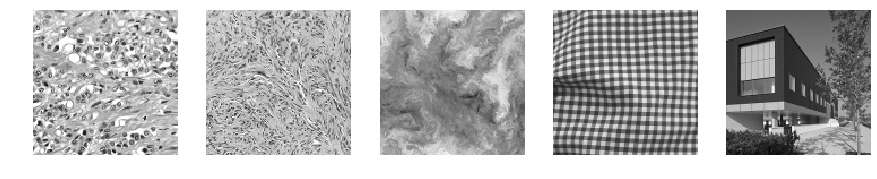

In [4]:
plt.rcParams["figure.figsize"] = (15,5)
figure, ax = plt.subplots(ncols=len(images))
for i, image in enumerate(images):
    ax[i].imshow(image, cmap='gray', vmin=0, vmax=1)
    ax[i].axis('off')
plt.show()

## Define scattering moments

Because we want a translation-invariant model, the wavelet decomposition is performed for all scales `J` in order to get the average value as the output of the scattering transform. See https://www.kymat.io/userguide.html. `L` is the number of scattering angles. 

In [5]:
# Define Wavelet Scattering Transform
print("Defining WST (this step can be slow)...")
L = 4
J = int(np.log2(images[0].shape[0])) # Full scale for stationary processes
print(J)
wst = Scattering2D(J, images[0].shape, L=L)
wst = wst.cuda()

def S(x):
    """Define scattering transform"""
    return wst(x).flatten()

Defining WST (this step can be slow)...
7


## Particles method

We define a set of particles which serves to calculate the image as a smoothed density field (see `get_field` function). We are going to optimize both positions $x$ and $y$, and prefactor $a$.

In [6]:
# Number of particles
N = 10_000

# Define particle positions:
x = torch.empty(N, requires_grad=True, device=device)
y = torch.empty(N, requires_grad=True, device=device)
a = torch.ones(1, requires_grad=True, device=device)

# Define grid
cols = torch.outer(torch.ones(images[0].shape[0], device=device), torch.arange(images[0].shape[0], device=device))
rows = torch.outer(torch.arange(images[0].shape[0], device=device), torch.ones(images[0].shape[0], device=device))

In [7]:
# Initialize with random values
with torch.no_grad():
    x.uniform_(0, images[0].shape[0])
    y.uniform_(0, images[0].shape[0])
    
def get_field(x, y, a, var=1):
    """Get a uniform field based on positions x and y"""
    field = torch.ones_like(cols, device=device)
    for xi, yi in zip(x, y):
        #field -= a*torch.exp(-((cols-xi)**2 + (rows-yi)**2)/(2*var))
        field -= a*torch.exp(-((cols-xi)**2 + (rows-yi)**2)**0.5/(2*var))
    return field

Lets see the field:

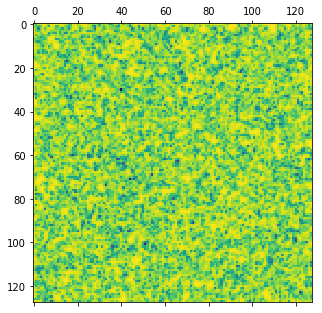

In [8]:
with torch.no_grad():
    plt.matshow(get_field(x, y, a, var=0.2).cpu())

## Micro-canonical method

In this method, we generate a new texture, $\varphi_1$, such that:
$$
\varphi_1 = \arg \min_{\varphi}\left(|S(\varphi)-S(\varphi_0)|^2  \right)
$$
where $S(\varphi)$ is the scattering transform of the continuious field $\varphi(x,y,a)$ and $\varphi_0$ is the example image. In other words, we use an optimization process to move the particles so that $\varphi_1$ has the same scattering moments as the example. 

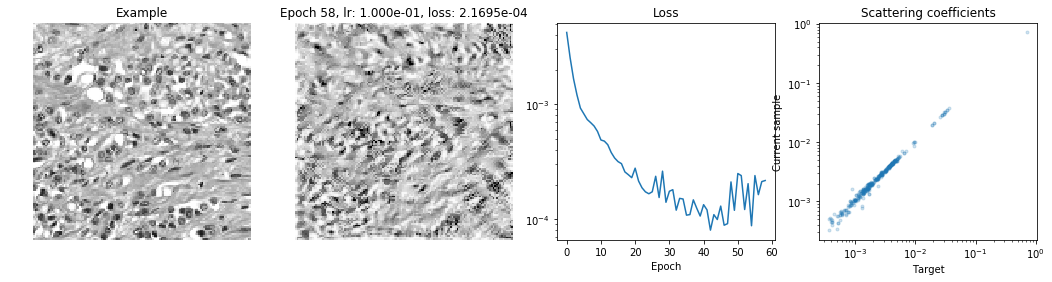

KeyboardInterrupt: 

In [9]:
# Select image number
i = 0

# Compute scattering transform of the example
image = images[i]
S0 = S(torch.from_numpy(image).to(device).contiguous())

S0_plot = S0.detach().cpu()


# Optimizer
# ---------
optimizer = optim.Adam([x, y, a], lr=0.1)
#optimizer = optim.SGD([x, y, a], lr=1e4, momentum=0.9, dampening=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=100)

# Optional: annealing (introduces noise in the particle motion)
annealing = False
if annealing:
    # Noise tensor
    Wx = torch.randn(N, device=device)
    Wy = torch.randn(N, device=device)
    # step (in pixels unit)
    sigma = 0.05


# Optimization loop
# -----------------
max_iter = 10_000
losses = []

for epoch in range(max_iter):
    field = get_field(x, y, a, var=0.2)
    S1 = S(field)
    #loss = F.mse_loss(input=S1, target=S0)
    #loss = F.smooth_l1_loss(input=S1, target=S0, beta=1.3e-3)
    loss = F.l1_loss(input=S1, target=S0)
    loss.backward()
    optimizer.step()
    
    if annealing:
        with torch.no_grad():
            # Add updated random noise
            x += sigma*Wx.normal_()
            y += sigma*Wy.normal_()
    
    optimizer.zero_grad()
    scheduler.step(loss.item())
    losses.append(loss.item())
    
    if True:
        # Plotting
        current_image = field.detach().cpu().numpy()
        clear_output(wait=True)
        
        
        plt.rcParams["figure.figsize"] = (18,4)
        figure, ax = plt.subplots(ncols=4)
        ax[0].imshow(image, cmap='gray', vmin=0, vmax=1)
        ax[0].set_title("Example")
        ax[0].axis('off')

        ax[1].imshow(current_image, cmap='gray', vmin=0, vmax=1)
        #ax[1].set_title(f"Epoch {epoch}, lr: {scheduler.get_last_lr()[0]:1.6f}, loss: {loss.item():1.3e}")
        ax[1].set_title(f"Epoch {epoch}, lr: {scheduler._last_lr[0]:1.3e}, loss: {loss.item():1.4e}")
        ax[1].axis('off')

        if len(losses) < 50:
            ls = 'o-'
        else:
            ls = '-'
        ax[2].semilogy(losses, ls)
        ax[2].set_xlabel('Epoch')
        ax[2].set_title('Loss')
        
        
        ax[3].loglog(S0_plot, S1.detach().cpu(), '.', alpha=0.2)
        ax[3].set_title('Scattering coefficients')
        ax[3].set_xlabel('Target')
        ax[3].set_ylabel('Current sample')
        plt.show()

## Save

In [ ]:
now = datetime.datetime.now()

x1 = field.detach().cpu().numpy()
x1[x1>1] = 1
x1[x1<0] = 0
io.imsave(f'outputs/{now.strftime("%Y-%m-%d %H:%M:%S")}_J{J}_L{L}_output.tiff', img_as_ubyte(x1))